In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from sys import path
path.append('..')
from statistical_clear_sky.algorithm.iterative_fitting import IterativeFitting
from statistical_clear_sky.solver_type import SolverType
from statistical_clear_sky.utilities.data_conversion import make_time_series
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
PLOT_ARGS = {
    'linewidth': 1,
    'figsize': (12,8)
}
from time import time
from datetime import datetime
from os.path import expanduser
from scipy.interpolate import interp1d
from scipy.stats import kstest

In [37]:
def threshold(alpha, n1, n2):
    c1 = np.sqrt(-0.5 * np.log(alpha / 2.))
    c2 = np.sqrt((n1 + n2) * 1. / (n1 * n2))
    return c1 * c2

In [38]:
def reverseThreshold(D, n1, n2):
    c2 = np.sqrt((n1 + n2) * 1. / (n1 * n2))
    return 2 * np.exp(-2 * (D / c2)**2)

## S47 - 6 months of data

In [39]:
ti = time()
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADHC1036570')
        and meas_name = 'ac_power';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)
df = make_time_series(df, return_keys=False).fillna(0)
days = df.resample('D').max().index[1:-1]
start = days[0].strftime('%m/%d/%y')
end = days[-1].strftime('%m/%d/%y')
tf = time()
print(start, end)
print('data loading took {:.2f} seconds'.format(tf-ti))

04/10/15 03/11/19
data loading took 10.90 seconds


In [40]:
p = df.loc[start:end].values
power_signals_d = df.loc[start:end].values.reshape(288, -1, order='F')[:, :365//2]

In [41]:
power_signals_d.shape

(288, 182)

In [42]:
iterative_fitting = IterativeFitting(power_signals_d, rank_k=5, reserve_test_data=0.1, solver_type=SolverType.mosek)

In [43]:
iterative_fitting.test_days

array([  3,  13,  21,  24,  25,  27,  31,  50,  51,  55,  58,  83,  87,
        96, 123, 138, 158, 170])

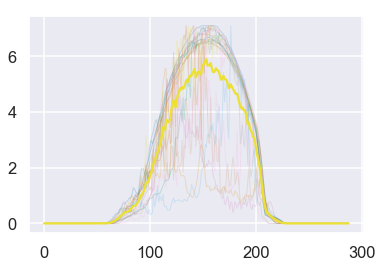

In [44]:
plt.plot(power_signals_d[:, iterative_fitting.test_days], linewidth=1, alpha=0.2)
plt.plot(np.average(power_signals_d[:, iterative_fitting.test_days], axis=1))
plt.show()

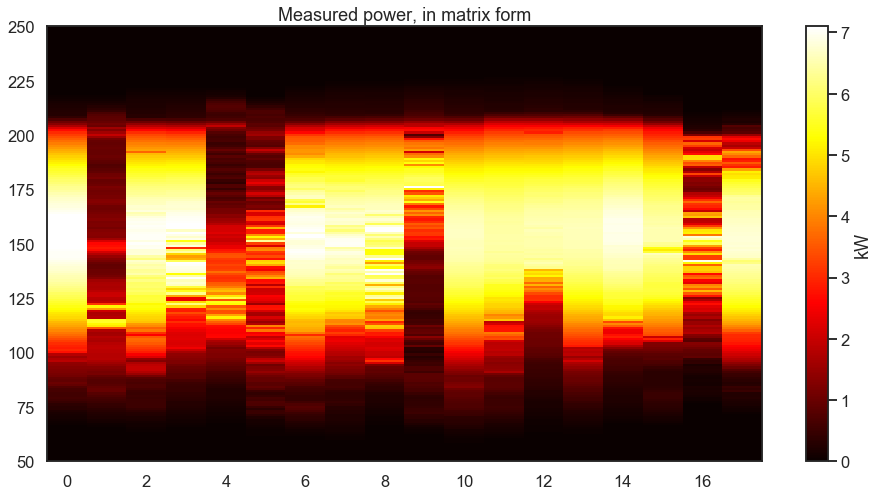

In [45]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(iterative_fitting.power_signals_d[:, iterative_fitting.test_days], cmap='hot', aspect='auto', interpolation='none')
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')
    plt.ylim(50, 250)

In [46]:
iterative_fitting.execute(mu_l=5e2, mu_r=1e3, tau=0.9, max_iteration=12)

obtaining initial value of component r0
obtaining weights
starting at 326384.216 [606.3472352003978, 318.13229439724944, 325459.7369675509, 0]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 372.865 [336.628   9.609  26.629   0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 343.610 [307.877   9.185  26.549   0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 339.273 [301.844  10.761  26.669   0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 337.322 [299.121  11.328  26.873   0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 336.685 [297.731  11.926  27.028   0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 336.366 [297.074  12.109  27.183   0.   ]
Minimization complete in 0.62 minutes


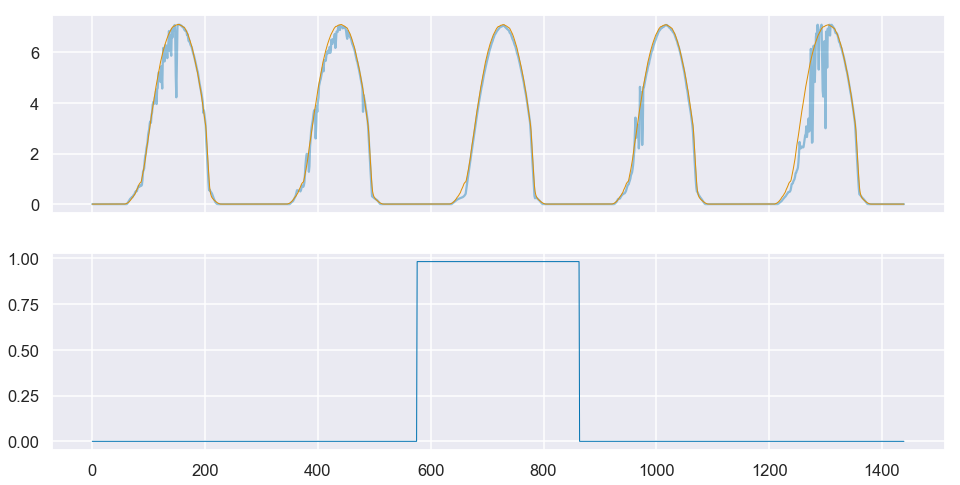

In [47]:
d1 = 20
d2 = d1+5
actual = p[d1*288:d2*288]
clearsky = ((iterative_fitting.clear_sky_signals()))[:, d1:d2].ravel(order='F')
fig, ax = plt.subplots(nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(actual, alpha=0.4)
ax[0].plot(clearsky, linewidth=1)
ax[1].plot(np.repeat(iterative_fitting.weights[d1:d2], 288), linewidth=1)

In [48]:
clearsky = np.asarray(iterative_fitting.clear_sky_signals())

In [49]:
clearsky.shape

(288, 182)

In [50]:
iterative_fitting.test_days
train_days = np.array(list(set(range(clearsky.shape[1])).difference(iterative_fitting.test_days)))

In [51]:
daytime = np.logical_not(np.isclose(iterative_fitting.power_signals_d, 0, atol=1e-3))
residuals_train = iterative_fitting.power_signals_d[:, train_days][daytime[:, train_days]] - iterative_fitting.clear_sky_signals()[:, train_days][daytime[:, train_days]]
residuals_test = iterative_fitting.power_signals_d[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]] - iterative_fitting.clear_sky_signals()[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]]

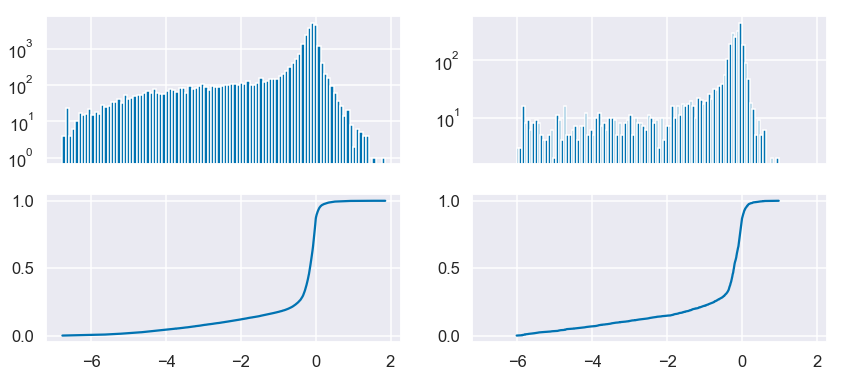

In [52]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
ax[0, 0].set_yscale('log')
ax[0, 0].hist(residuals_train, bins=100)
ax[0, 1].set_yscale('log')
ax[0, 1].hist(residuals_test, bins=100)
ax[1, 0].plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))
ax[1, 1].plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False))
plt.show()

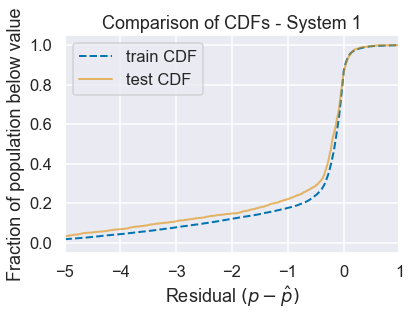

In [53]:
plt.plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False), linewidth=2, ls='--', label='train CDF')
plt.plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False), linewidth=2, alpha=0.6, label='test CDF')
plt.xlim(-5, 1)
plt.title('Comparison of CDFs - System 1')
plt.xlabel('Residual $(p - \\hat{p})$')
plt.ylabel('Fraction of population below value')
plt.legend(loc=2)

In [54]:
cdf = interp1d(np.r_[np.min(residuals_test), np.sort(residuals_train)[1:-1], np.max(residuals_test)], np.linspace(0, 1, len(residuals_train), endpoint=False))
#cdf = interp1d(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))

In [55]:
stat, pval = kstest(residuals_test, cdf)
stat

0.09496100429221577

In [56]:
alpha = reverseThreshold(stat, len(residuals_train), len(residuals_test))
print('Probability of incorrectly rejecting null hypothesis: {:.2e}'.format(alpha))

Probability of incorrectly rejecting null hypothesis: 9.05e-21


## S07 - 3years of data

In [57]:
ti = time()
home = expanduser("~")
with open(home+'/.aws/cassandra_cluster') as f:
    cluster_ip = f.readline().strip('\n')
cluster = Cluster([cluster_ip])
session = cluster.connect('measurements')
cql = """
    select site, meas_name, ts, sensor, meas_val_f 
    from measurement_raw
    where site in ('TADBC1078041')
        and meas_name = 'ac_power';
"""
rows = session.execute(cql)
df = pd.DataFrame(list(rows), )
df.replace(-999999.0, np.NaN, inplace=True)
df = make_time_series(df, return_keys=False).fillna(0)
days = df.resample('D').max().index[1:-1]
start = days[0].strftime('%m/%d/%y')
end = days[-1].strftime('%m/%d/%y')
tf = time()
print(start, end)
print('data loading took {:.2f} seconds'.format(tf-ti))

04/25/15 11/15/18
data loading took 7.99 seconds


In [58]:
power_signals_d = df.loc[start:end].values.reshape(288, -1, order='F')
p = df.loc[start:end]
iterative_fitting = IterativeFitting(power_signals_d, rank_k=5, reserve_test_data=0.1, solver_type=SolverType.mosek)

In [59]:
iterative_fitting.test_days

array([  11,   12,   17,   43,   47,   53,   61,   63,   73,   88,   90,
         98,  101,  176,  177,  212,  221,  225,  233,  235,  242,  243,
        250,  256,  266,  268,  293,  300,  314,  340,  345,  357,  359,
        360,  382,  410,  412,  417,  420,  428,  439,  455,  471,  472,
        485,  493,  500,  509,  529,  539,  545,  556,  558,  560,  561,
        569,  579,  585,  608,  627,  674,  686,  689,  692,  707,  714,
        734,  735,  739,  749,  754,  768,  788,  790,  798,  801,  803,
        808,  812,  818,  819,  824,  828,  866,  868,  871,  881,  903,
        917,  919,  922,  932,  933,  936,  942,  958,  965,  979,  996,
       1009, 1011, 1020, 1021, 1024, 1031, 1048, 1071, 1077, 1078, 1085,
       1089, 1102, 1106, 1107, 1123, 1129, 1140, 1141, 1156, 1158, 1164,
       1217, 1226, 1227, 1230, 1254, 1273, 1277, 1286, 1292])

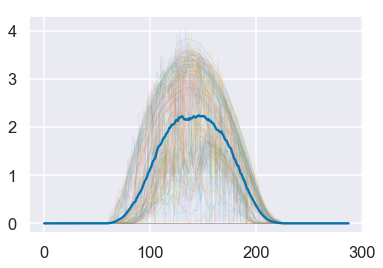

In [60]:
plt.plot(power_signals_d[:, iterative_fitting.test_days], linewidth=1, alpha=0.1)
plt.plot(np.average(power_signals_d[:, iterative_fitting.test_days], axis=1))
plt.show()

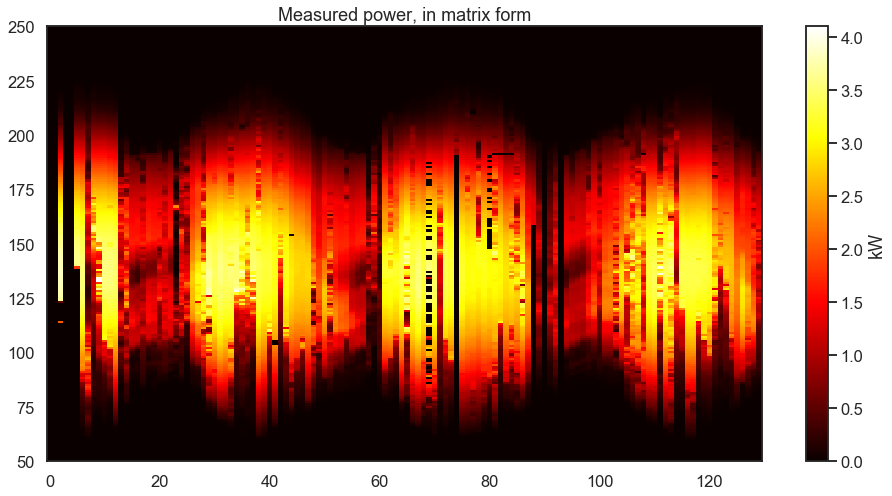

In [61]:
with sns.axes_style("white"):
    fig = plt.figure(figsize=(16,8))
    plt.imshow(iterative_fitting.power_signals_d[:, iterative_fitting.test_days], cmap='hot', interpolation='none', aspect='auto')
    plt.colorbar(label='kW')
    plt.title('Measured power, in matrix form')
    plt.ylim(50, 250)

In [62]:
iterative_fitting.execute(mu_l=5e2, mu_r=1e3, tau=0.9, max_iteration=8)

obtaining initial value of component r0
obtaining weights
starting at 519819.649 [2252.2733870313327, 121.27887428457726, 383794.4745746646, 133651.6221204704]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 1967.373 [1745.656   15.119  206.598    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 1699.970 [1490.28    14.961  194.729    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 1674.822 [1466.716   17.974  190.133    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 1665.295 [1459.619   19.058  186.617    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 1659.735 [1456.812   19.418  183.506    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 1655.570 [1455.048   19.805  180.717    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 7: 1652.306 [1453.996   20.038  178.272    0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 8:

In [63]:
train_days = np.array(list(set(range(clearsky.shape[1])).difference(iterative_fitting.test_days)))

In [64]:
daytime = np.logical_not(np.isclose(iterative_fitting.power_signals_d, 0, atol=1e-3))
residuals_train = iterative_fitting.power_signals_d[:, train_days][daytime[:, train_days]] - iterative_fitting.clear_sky_signals()[:, train_days][daytime[:, train_days]]
residuals_test = iterative_fitting.power_signals_d[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]] - iterative_fitting.clear_sky_signals()[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]]

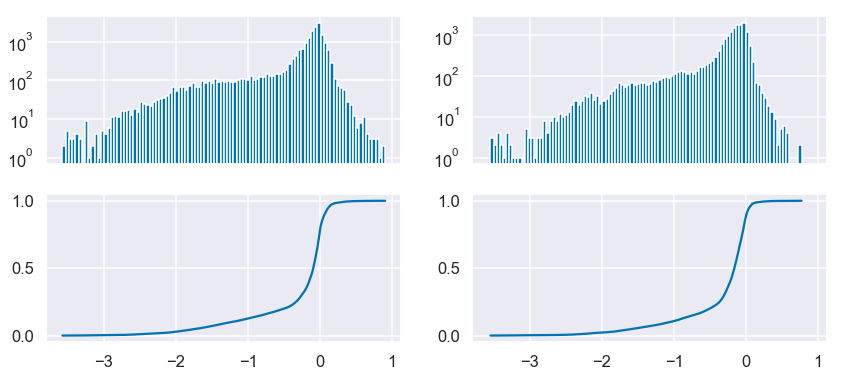

In [65]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
ax[0, 0].set_yscale('log')
ax[0, 0].hist(residuals_train, bins=100)
ax[0, 1].set_yscale('log')
ax[0, 1].hist(residuals_test, bins=100)
ax[1, 0].plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))
ax[1, 1].plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False))
plt.show()

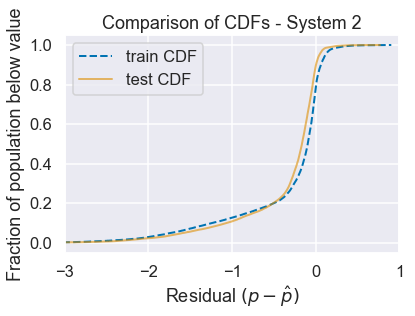

In [66]:
plt.plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False), linewidth=2, ls='--', label='train CDF')
plt.plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False), linewidth=2, alpha=0.6, label='test CDF')
plt.xlim(-3, 1)
plt.title('Comparison of CDFs - System 2')
plt.xlabel('Residual $(p - \\hat{p})$')
plt.ylabel('Fraction of population below value')
plt.legend(loc=2)

In [67]:
cdf = interp1d(np.r_[np.min(residuals_test), np.sort(residuals_train)[1:-1], np.max(residuals_test)], np.linspace(0, 1, len(residuals_train), endpoint=False))
#cdf = interp1d(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))

In [68]:
stat, pval = kstest(residuals_test, cdf)
stat

0.15765863626204113

In [69]:
alpha = reverseThreshold(stat, len(residuals_train), len(residuals_test))
print('Probability of incorrectly rejecting null hypothesis: {:.2e}'.format(alpha))

Probability of incorrectly rejecting null hypothesis: 4.40e-198


# ERE Data - 1 Year

In [74]:
data = np.load('../data/stanford_university/Huang_PV_data_Jan2016_Feb2018.npy')
p = data.ravel(order='F')

In [75]:
iterative_fitting = IterativeFitting(data, rank_k=5, reserve_test_data=0.1, solver_type=SolverType.mosek)

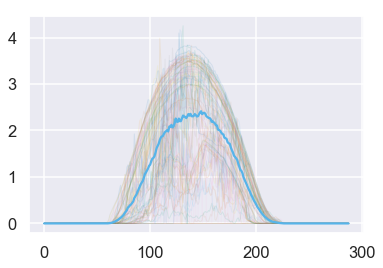

In [76]:
plt.plot(power_signals_d[:, iterative_fitting.test_days], linewidth=1, alpha=0.1)
plt.plot(np.average(power_signals_d[:, iterative_fitting.test_days], axis=1))
plt.show()

In [77]:
iterative_fitting.execute(mu_l=1e4, mu_r=5e3, tau=0.9, max_iteration=10)

obtaining initial value of component r0
obtaining weights
starting at 33068498.775 [46328.7671277424, 2696.324801471715, 26705946.542505328, 6313527.140111118]
Miminizing left L matrix
Miminizing right R matrix
iteration 1: 35879.500 [3.0907279e+04 2.7911000e+01 4.9443110e+03 0.0000000e+00]
Miminizing left L matrix
Miminizing right R matrix
iteration 2: 31089.427 [26262.953    59.588  4766.885     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 3: 30594.485 [25766.901    76.116  4751.468     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 4: 30489.153 [25665.943    78.148  4745.063     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 5: 30416.898 [25599.085    80.515  4737.298     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 6: 30363.470 [25557.82     82.763  4722.887     0.   ]
Miminizing left L matrix
Miminizing right R matrix
iteration 7: 30323.543 [25532.281    85.098  4706.163     0.   ]
Miminizing l

In [78]:
train_days = np.array(list(set(range(clearsky.shape[1])).difference(iterative_fitting.test_days)))

In [79]:
daytime = iterative_fitting.power_signals_d >= 1e-3
residuals_train = iterative_fitting.power_signals_d[:, train_days][daytime[:, train_days]] - iterative_fitting.clear_sky_signals()[:, train_days][daytime[:, train_days]]
residuals_test = iterative_fitting.power_signals_d[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]] - iterative_fitting.clear_sky_signals()[:, iterative_fitting.test_days][daytime[:, iterative_fitting.test_days]]

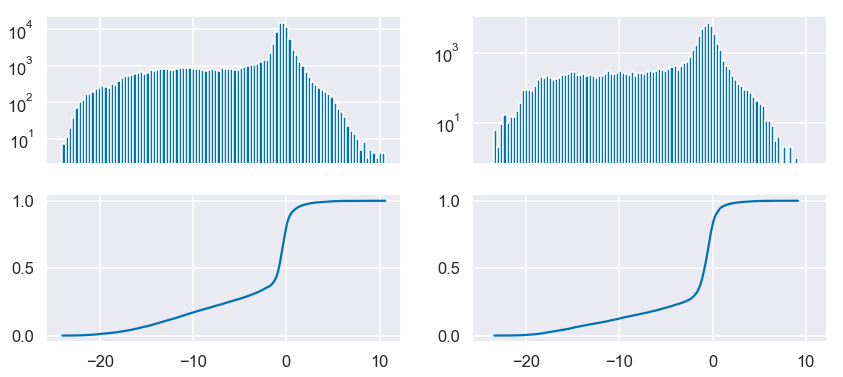

In [80]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6), sharex=True)
ax[0, 0].set_yscale('log')
ax[0, 0].hist(residuals_train, bins=100)
ax[0, 1].set_yscale('log')
ax[0, 1].hist(residuals_test, bins=100)
ax[1, 0].plot(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))
ax[1, 1].plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False))
plt.show()

In [81]:
cdf = interp1d(np.r_[np.min(residuals_test), np.sort(residuals_train)[1:-1], np.max(residuals_test)], np.linspace(0, 1, len(residuals_train), endpoint=False))
#cdf = interp1d(np.sort(residuals_train), np.linspace(0, 1, len(residuals_train), endpoint=False))

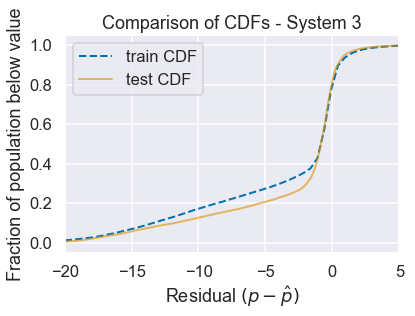

In [82]:
plt.plot(np.linspace(-20,5), cdf(np.linspace(-20,5)), linewidth=2, ls='--', label='train CDF')
plt.plot(np.sort(residuals_test), np.linspace(0, 1, len(residuals_test), endpoint=False), linewidth=2, alpha=0.6, label='test CDF')
plt.xlim(-20, 5)
plt.title('Comparison of CDFs - System 3')
plt.xlabel('Residual $(p - \\hat{p})$')
plt.ylabel('Fraction of population below value')
plt.legend(loc=2)

In [83]:
stat, pval = kstest(residuals_test, cdf)
stat

0.07450046956407969

In [84]:
alpha = reverseThreshold(stat, len(residuals_train), len(residuals_test))
print('Probability of incorrectly rejecting null hypothesis: {:.2e}'.format(alpha))

Probability of incorrectly rejecting null hypothesis: 1.90e-172
